In [2]:
from make_ewma_features_df import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Function to fit and test model

In [3]:
def test_model(ewma_merge_lag):
	rmse_dict = {}
	for pos in ['FWD', 'MID', 'DEF', 'GK']:
		ewma_merge_lag_pos = ewma_merge_lag.query('position==@pos').set_index(['full_name', 'gw'])
		X = ewma_merge_lag_pos[[
			'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
			'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
			'minutes', 'ewma_total_points', 'ewma_team_goals',
			'ewma_nw_opponent_goals']]

		y = ewma_merge_lag_pos['nw_total_points']

		X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

		model = LinearRegression()
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)

		rmse = root_mean_squared_error(y_test, y_pred)
		# mae = mean_absolute_error(y_test, y_pred)

		rmse_dict[pos] = [rmse]
	return rmse_dict

# Testing alpha for EWMA between 0-1

In [4]:
# rmse_dict = test_model(ewma_merge_lag)
# rmse_full_dict = rmse_dict.copy()
rmse_full_dict = {'FWD': [], 'MID': [], 'DEF': [], 'GK': []}
alpha_list = []
for i in np.arange(0.05, 1, 0.05):
    ewma_merge_lag = make_ewma_features_df(25, i)
    ewma_merge_lag = ewma_merge_lag.dropna()
    rmse_dict = test_model(ewma_merge_lag)
    alpha_list.append(i)
    for pos in ['FWD', 'MID', 'DEF', 'GK']:
        rmse_full_dict[pos].extend(rmse_dict[pos])
rmse_df = pd.DataFrame(rmse_full_dict, index=alpha_list)


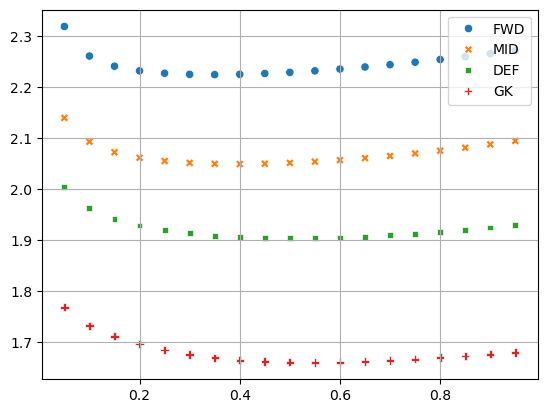

In [5]:
sns.scatterplot(rmse_df)
plt.grid()

0.4 looks like a good balance

# Testing for 2024 data to see if it's consistent

In [8]:
# rmse_dict = test_model(ewma_merge_lag)
# rmse_full_dict = rmse_dict.copy()
rmse_full_dict = {'FWD': [], 'MID': [], 'DEF': [], 'GK': []}
alpha_list = []
for i in np.arange(0.05, 1, 0.05):
    ewma_merge_lag = make_ewma_features_df(24, i)
    ewma_merge_lag = ewma_merge_lag.dropna()
    rmse_dict = test_model(ewma_merge_lag)
    alpha_list.append(i)
    for pos in ['FWD', 'MID', 'DEF', 'GK']:
        rmse_full_dict[pos].extend(rmse_dict[pos])
rmse_df = pd.DataFrame(rmse_full_dict, index=alpha_list)


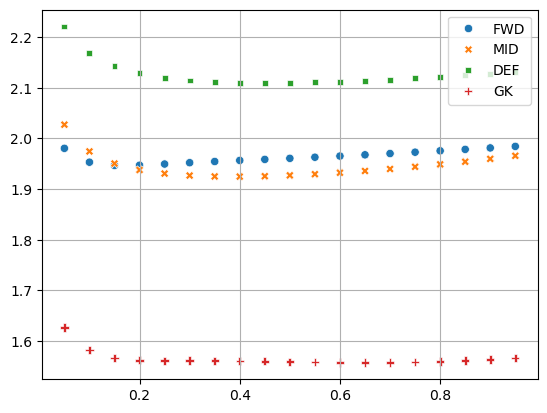

In [9]:
sns.scatterplot(rmse_df)
plt.grid()

The data is very different but 0.4 is still a good place to put the ewma alpha

In [10]:
# rmse_dict = test_model(ewma_merge_lag)
# rmse_full_dict = rmse_dict.copy()
rmse_full_dict = {'FWD': [], 'MID': [], 'DEF': [], 'GK': []}
alpha_list = []
for i in np.arange(0.05, 1, 0.05):
    ewma_merge_lag = make_ewma_features_df(23, i)
    ewma_merge_lag = ewma_merge_lag.dropna()
    rmse_dict = test_model(ewma_merge_lag)
    alpha_list.append(i)
    for pos in ['FWD', 'MID', 'DEF', 'GK']:
        rmse_full_dict[pos].extend(rmse_dict[pos])
rmse_df = pd.DataFrame(rmse_full_dict, index=alpha_list)


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\draft_fpl_2526\transfer\make_ewma_features_df.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)
c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\draft_fpl_2526\transfer\make_ewma_features_df.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)
c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\draft_fpl_2526\transfer\make_ewma_features_df.py:13: FutureWarning: The behavior of Da

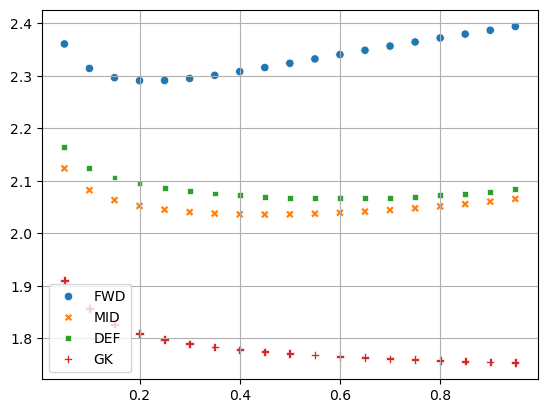

In [11]:
sns.scatterplot(rmse_df)
plt.grid()